### Podatkovno rudarjenje, 2. domača naloga, 4. 4. 2018

# Iskanje strukture v podatkih

**Jaka Jenko**

Z modeliranjem skušamo poiskati strukturo v podatkih. Z metodami nenadzorovanga modeliranja skušamo poiskati skupine podobnih podatkov oz. skupine primerov.

V nalogi boste uporabili modeliranje verjetnostnih porazdelitev za iskanje osamelcev ter metode za iskanje skupin podobnih primerov (gručenje).

## Podatki

Opis podatkovne zbirke MovieLens ostaja enak prvi nalogi.

## Vprašanja

Z uporabo principov, ki ste jih spoznali na vajah in predavanjih, odgovorite na
spodnja vprašanja. Pri vsakem vprašanju dobro premislite, na kakšen način boste
najbolje podali, prikazali oz. utemeljili odgovor. Bistven del so odgovori na
vprašanja in ne toliko implementacija vaše rešitve.

In [35]:
import math
import operator
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from csv import DictReader

import scipy.cluster.hierarchy as sch
import scipy

from scipy.stats import multivariate_normal as mvn
from scipy.stats import t as student 

reader = DictReader(open('ml-latest-small/ratings.csv', 'rt', encoding='utf-8'))
moviesRatings = {}
usersRatings = {}

for row in reader:
    #print(row)
    if row["movieId"] in moviesRatings:
        moviesRatings[row["movieId"]].append(row)
    else:
        moviesRatings[row["movieId"]] = [row]
        
    if row["userId"] in usersRatings:
        usersRatings[row["userId"]].append(row)
    else:
        usersRatings[row["userId"]] = [row]
        
        
reader = DictReader(open('ml-latest-small/movies.csv', 'rt', encoding='utf-8'))
movies = {}

for row in reader:
    movies[row["movieId"]] = row
    movies[row["movieId"]]["avgRating"] = -1
    movies[row["movieId"]]["variance"] = -1
    movies[row["movieId"]]["numOfRatings"] = -1
    
#print(moviesRatings)
    
#reader = DictReader(open('ml-latest-small/cast.csv', 'rt', encoding='utf-8'))
#moviesCast = {}

#for row in reader:
#    moviesCast[row["movieId"]] = row["cast"]

### 1. Iskanje osamelcev (50%) 
O ocenah katerih filmov so si uporabniki najmanj enotni? Povedano drugače, za katere filme so pripadajoče ocene najbolj razpršene?

Formuliraj problem kot modeliranje verjetnostne porazdelitve. Premisli o naslednjih vprašanjih, naredi ustrezne poizkuse in odgovori.

In [36]:
for movieRatingsData in moviesRatings.values():
    avg = 0
    i = 0
    onlyRatings = []
    #print(movieRatingsData)
    for rating in movieRatingsData:
        #print(rating["rating"])
        avg += float(rating["rating"])
        i += 1
        onlyRatings.append(float(rating["rating"]))
        
    #print(onlyRatings)
    movies[rating["movieId"]]["avgRating"] = avg/i
    movies[rating["movieId"]]["variance"] = np.var(onlyRatings)
    movies[rating["movieId"]]["numOfRatings"] = i
    
print("Glede na vse")
top10 = []
for i in range(0, 10):
    maxRating = 0
    for  movie in movies.values():
        #print(max)
        #print(movie)
        if movie not in top10 and (maxRating == 0 or movie["variance"] > maxRating["variance"]):
            maxRating = movie
    
    top10.append(maxRating)
    print("Naslov: {:55s} Varianca: {:f} Povp. ocena: {:f} Št. ocen: {:d}".format(maxRating["title"], maxRating["variance"], maxRating["avgRating"], int(maxRating["numOfRatings"])))

print()
print("Št. ocen je vsaj 25")
top10 = []
for i in range(0, 10):
    maxRating = 0
    for  movie in movies.values():
        #print(max)
        #print(movie)
        if movie not in top10 and movie["numOfRatings"]>20 and (maxRating == 0 or movie["variance"] > maxRating["variance"]):
            maxRating = movie
    
    top10.append(maxRating)
    print("Naslov: {:55s} Varianca: {:f} Povp. ocena: {:f} Št. ocen: {:d}".format(maxRating["title"], maxRating["variance"], maxRating["avgRating"], int(maxRating["numOfRatings"])))

moviesAll = movies

movies = {}
for movieKey in moviesAll.keys():
    if moviesAll[movieKey]["numOfRatings"] > 25:
        movies[movieKey] = moviesAll[movieKey]

Glede na vse
Naslov: Hunted, The (2003)                                      Varianca: 5.062500 Povp. ocena: 2.750000 Št. ocen: 2
Naslov: In July (Im Juli) (2000)                                Varianca: 5.062500 Povp. ocena: 2.750000 Št. ocen: 2
Naslov: Day of the Beast, The (Día de la Bestia, El) (1995)     Varianca: 5.062500 Povp. ocena: 2.750000 Št. ocen: 2
Naslov: Twilight Saga: Breaking Dawn - Part 1, The (2011)       Varianca: 4.000000 Povp. ocena: 2.500000 Št. ocen: 2
Naslov: American Pimp (1999)                                    Varianca: 4.000000 Povp. ocena: 3.000000 Št. ocen: 2
Naslov: Gloria (1980)                                           Varianca: 4.000000 Povp. ocena: 3.000000 Št. ocen: 2
Naslov: Numbskull Emptybrook (Uuno Turhapuro) (1973)            Varianca: 4.000000 Povp. ocena: 2.500000 Št. ocen: 2
Naslov: No Holds Barred (1989)                                  Varianca: 4.000000 Povp. ocena: 3.000000 Št. ocen: 2
Naslov: Anatomy (Anatomie) (2000)                  

Odgovor: **Za zgornje filme so so ocene najbolj razpršene.**

**V nadaljevanju bom uporabljal samo filme z >25 ocenami**

### 1.1. vprašanje:

Katera je ustrezna naključna spremenljivka (količina) v podatkih, ki odgovarja na vprašanje?        

In [37]:
# kodo lahko razdelite v več celic

Odgovor: **Variance ocen filmov**

### 1.2. vprašanje:
Nariši njeno porazdelitev, npr., s pomočjo histograma.

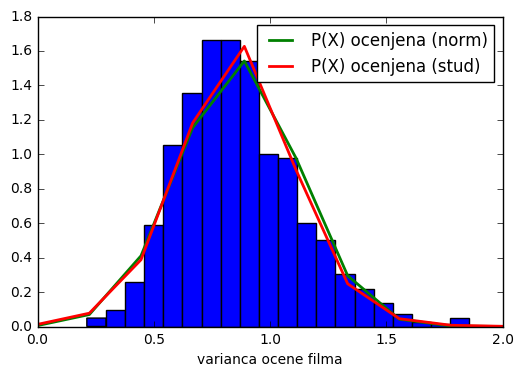

In [61]:
variances = []

for movie in movies.values():
    variances.append(movie["variance"])

#plt.figure(figsize=(9, 3))

n = len(variances)
xr = np.linspace(0, 2, 10)  

mu_fit = np.mean(variances)
sigma2_fit = (n-1)/n * np.var(variances)

P_fit_n = [mvn.pdf(x, mu_fit, sigma2_fit) for x in xr]

pars = student.fit(variances)

P_fit_s = [student.pdf(x, *pars) for x in xr ]

plt.hist(variances, normed=True, bins=20)
plt.plot(xr, P_fit_n, label="P(X) ocenjena (norm)", linewidth=2.0)
plt.plot(xr, P_fit_s, label="P(X) ocenjena (stud)", linewidth=2.0)
plt.xlabel("varianca ocene filma");
plt.legend();
plt.show()

Odgovor: **Na splošno je variance med ocenami posameznega filma dokaj malo. Najde pa se nekaj filmov, ki imajo kar veliko varianco. Če pogledamo nazaj 1. nalogo, vidimo, da so to predvsem filmi z malim št. ocen.**


**Odstranil sem filme brez, ali z samo 1 oceno, saj je varianca pri le-teh -1 (brez podatka) ali 0**

### 1.3. vprašanje:

Ali porazdelitev spominja na kakšno znano porazdelitev? Ali je porazdelitev morda normalna ali katera druga? 

In [62]:
# kodo lahko razdelite v več celic

Odgovor: **Porazdelitev izgleda normalna ali studentova.**

### 1.4. vprašanje:

Oceni parametre te porazdelitve s pomočjo postopkov, ki smo jih spoznali na vajah.  Izmed porazdelitev, ki smo jih spoznali na vajah, izberi tisto, ki se podatkom najbolj prilega.        

In [63]:
# kodo lahko razdelite v več celic

Odgovor: **odgovor lahko zapišete v več celic**

### 1.5. vprašanje:

Izpiši filme z vrednostjo naključne spremenljivke, ki spada v zgornjih 5% statistično značilnih primerov. 

In [64]:
maxVariance = max(variances)
minVariance = min(variances)

top5 = maxVariance-(((maxVariance-minVariance)/100)*5)

print("Najvišja varianca: ", maxVariance)
print("Majmanjša varianca: ", minVariance)
print("Zgornjih 5%: ", top5)
print()

for  movie in movies.values():
    #print(max)
    #print(movie)
    if movie["variance"] > top5 and movie:
        print("Naslov: {:55s} Varianca: {:f} Povp. ocena: {:f} Št. ocen: {:d}".format(movie["title"], movie["variance"], movie["avgRating"], int(movie["numOfRatings"])))


Najvišja varianca:  1.85612366231
Majmanjša varianca:  0.211428571429
Zgornjih 5%:  1.77388890776

Naslov: Mad Max: Fury Road (2015)                               Varianca: 1.802810 Povp. ocena: 3.790323 Št. ocen: 31
Naslov: Brokeback Mountain (2005)                               Varianca: 1.856124 Povp. ocena: 3.620690 Št. ocen: 29
Naslov: Patch Adams (1998)                                      Varianca: 1.827806 Povp. ocena: 3.107143 Št. ocen: 28
Naslov: Saw (2004)                                              Varianca: 1.849862 Povp. ocena: 3.272727 Št. ocen: 33


Odgovor: **odgovor lahko zapišete v več celic**

### 2. Gručenje filmov (50%)

Priporočilni sistemi pogosto odkrivajo skupine predmetov (v našem primeru filme), za katere velja visoka podobnost. 

Poiščite 100 najbolj gledanih filmov. Ali med njimi obstajajo skupine?
Uporabite ustrezen algoritem za gručenje. Na film lahko gledamo kot vektor, kjer je  
število komponent enako številu uporabnikov. 

Vektorji vsebujejo tudi *neznane vrednosti*.
Primer vektorjev za deset filmov prikazuje spodnja tabela.

Algoritme gručenja lahko izvajamo v izvornem prostoru (koordinatni sistem filmi-uporabniki) ali pa filme primerjamo z merami podobnosti, ki smo jih spoznali na vajah. 
Premisli, kateri način je primernejši glede na obliko podatkov.

| x          |Movie                                      | $u_0$ |$u_1$ | $u_2$ | $\cdots$ |
|------------|-------------------------------------------|:-----:|:----:|:------|:--------:|
|$\vec{x_0}$ | Fight Club (1999)                         | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_1}$ | Twelve Monkeys (a.k.a. 12 Monkeys) (1995) | ?     | ?    | 2.5   | $\cdots$ |
|$\vec{x_2}$ | Independence Day (a.k.a. ID4) (1996)      | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_3}$ | Dances with  Wolves (1990)                | 4.0   | ?    | ?     | $\cdots$ |
|$\vec{x_4}$ | Fargo (1996)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_5}$ | Speed (1994)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_6}$ | Apollo 13 (1995)                          | ?     | 2.0  | ?     | $\cdots$ |
|$\vec{x_7}$ | Seven (a.k.a. Se7en) (1995)               | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_8}$ | Sixth Sense, The (1999)                   | 3.0   | ?    | 4.0   | $\cdots$ |
|$\vec{x_9}$ | Aladdin (1992)                            | ?     | ?    | ?     | $\cdots$ |
|$\cdots$    | $\cdots$                                  | $\cdots$ | $\cdots$  | $\cdots$ | $\cdots$ |

Pri tem odgovori na naslednja vprašanja.

In [65]:
top100 = []
for i in range(0, 100):
    maxRating = 0
    for movie in movies.values():
        #print(max)
        #print(movie)
        if movie not in top100 and (maxRating == 0 or movie["numOfRatings"] > maxRating["numOfRatings"]):
            maxRating = movie
    
    top100.append(maxRating)

### 2.1. vprašanje:

Utemelji izbiro algoritma in mere podobnosti.

In [69]:
matrix = []
titles = []

for movie in top100:
    vrstica = []
    titles.append(movie["title"])
    
    for userRatings in usersRatings.values():
        #rat = np.nan
        rat = 0
        for rating in userRatings:
            if rating["movieId"] == movie["movieId"]:
                rat = rating["rating"]
                break
        
        vrstica.append(rat)
        
    matrix.append(vrstica)
        
#print(matrix[0])

Odgovor: **Uporabil sem hierarhično gručenje. To sem uporabil zaradi tega, ker ni potrebno v naprej predpostaviti št. skupin.**

### 2.2. vprašanje:

Koliko skupin filmov je med izbranimi? Ali poznamo kvantitativne ocene za različne možnosti razvrščanja v skupine?

In [70]:
# kodo lahko razdelite v več celic

Odgovor: **Glede na spodnjo vizaualizacijo (barve) je 14 skupin.**

### 2.3. vprašanje:

Prikaži rezultate z uporabo ustrezne vizualizacije.

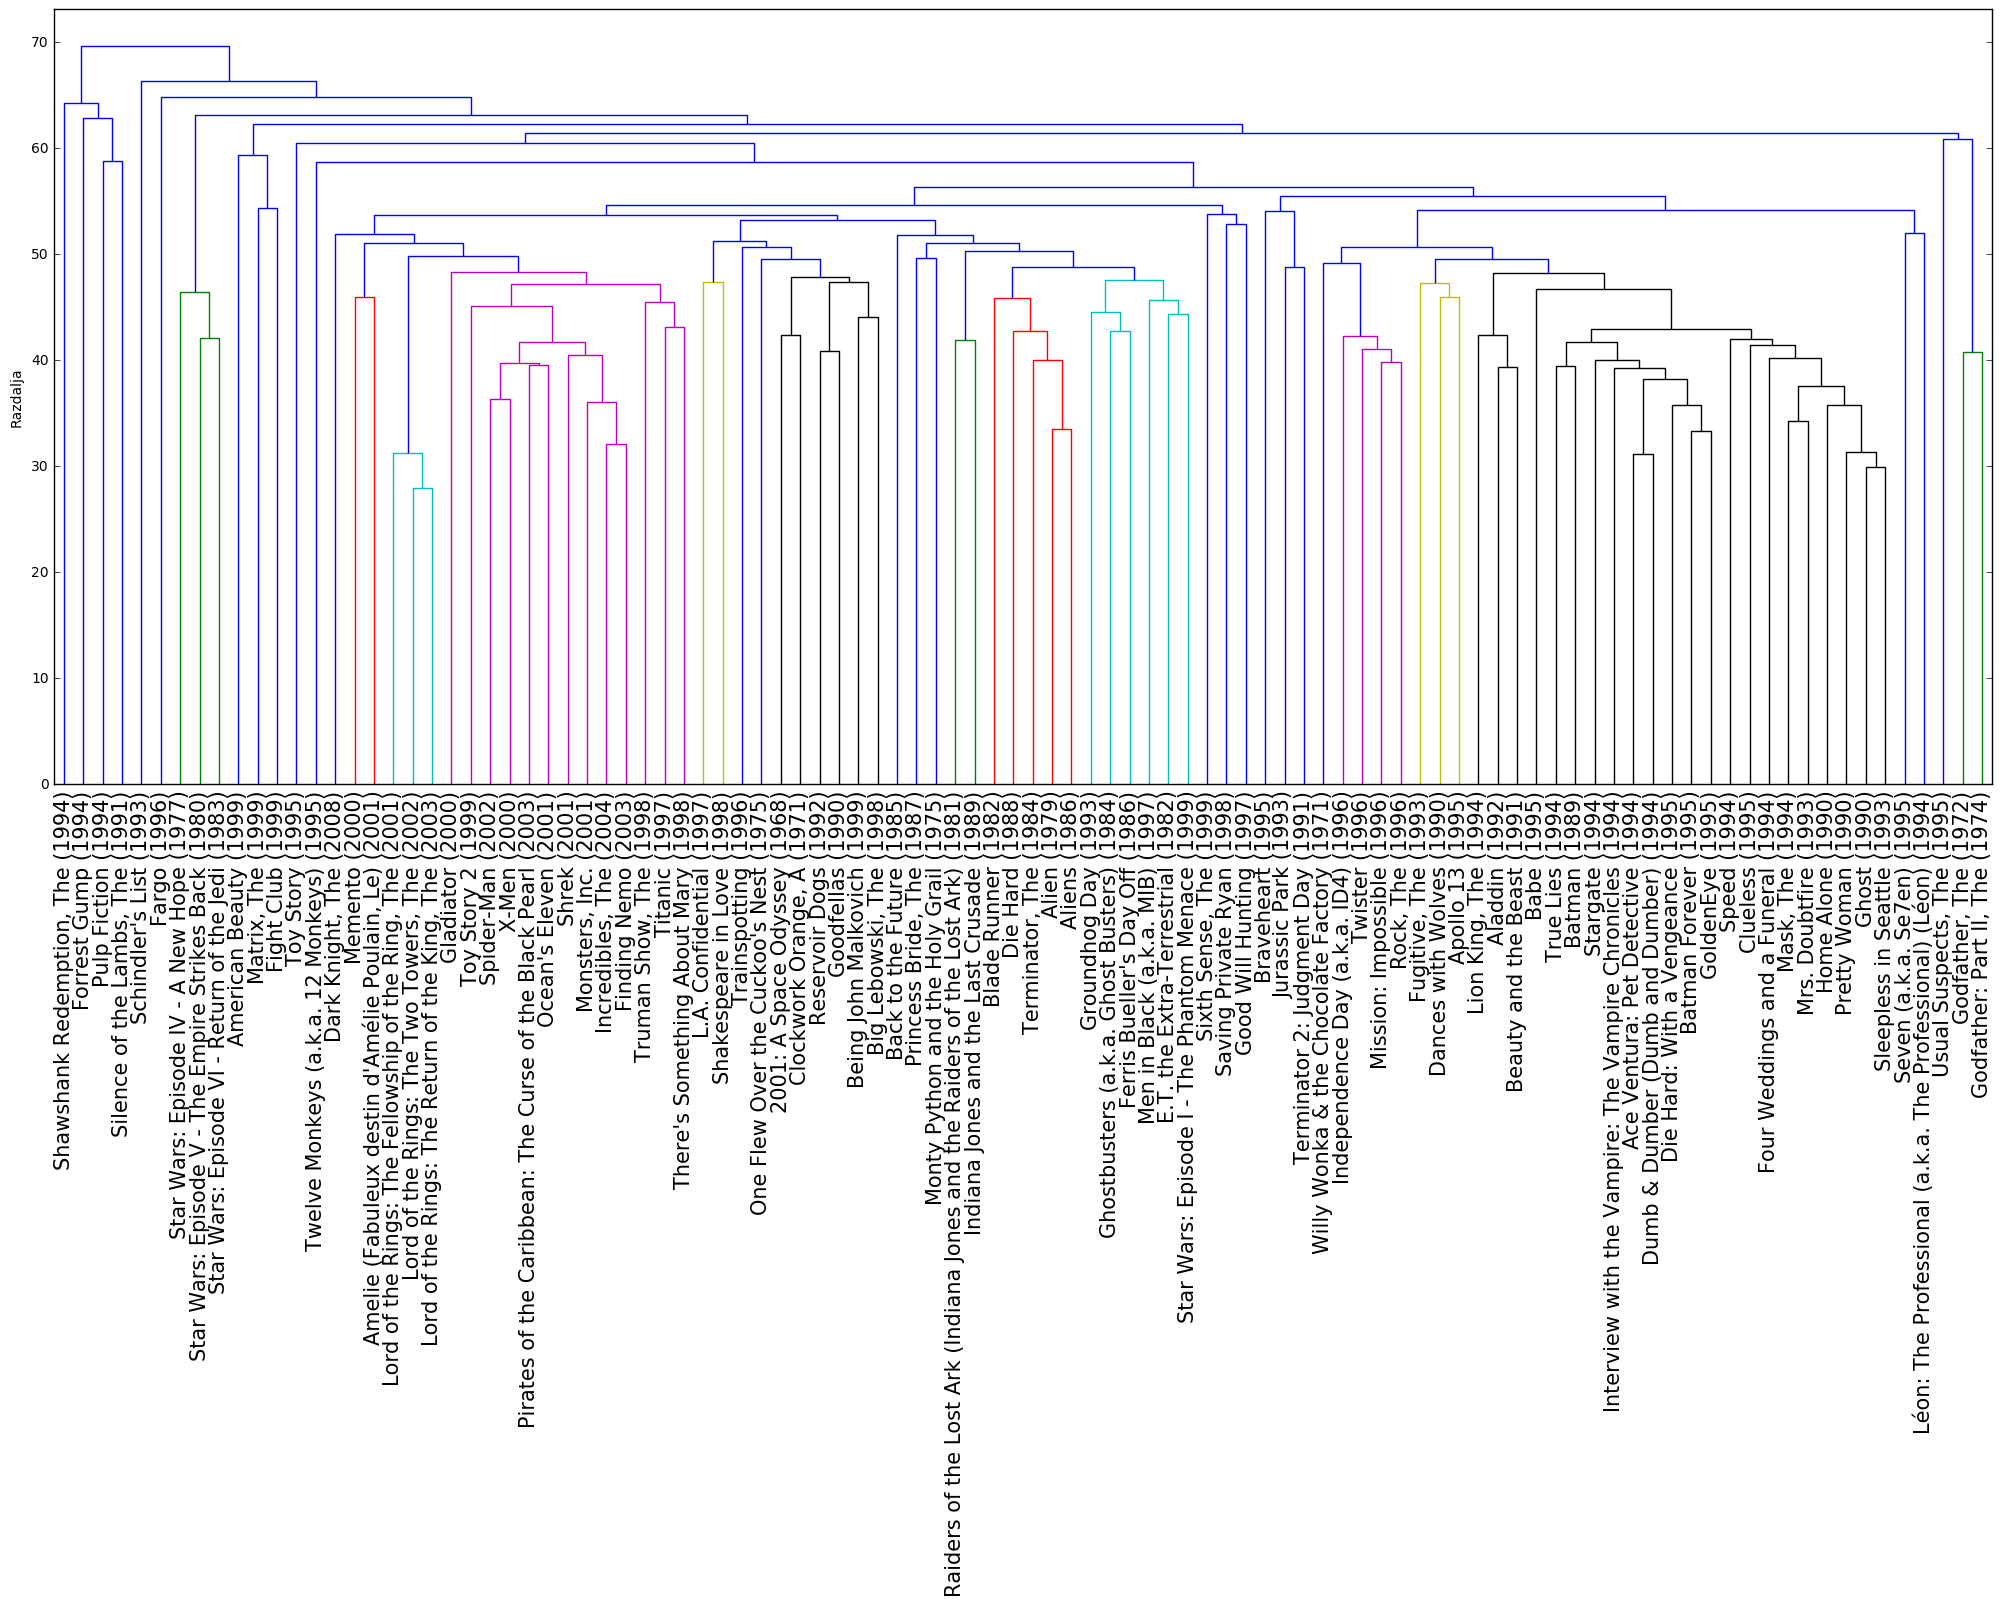

In [71]:
L = sch.linkage(np.asmatrix(matrix), method="average", metric="euclidean")
plt.figure(figsize=(25, 10))
labels = [row for row in titles]
D = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Razdalja")
plt.show()

Odgovor: **odgovor lahko zapišete v več celic**

### 2.4. vprašanje:

Komentiraj smiselnost dobljenih rezultatov.

In [10]:
# kodo lahko razdelite v več celic

Odgovor: **Če pogledamo naslove filmov, lahko vidimo, da so skupaj združeni filmi StarWars, Godfather, Pixar. Tako, da rezultati izgledajo dokaj smiselni.**